In [1]:
%load_ext autoreload

In [386]:
%autoreload 2
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc_VAR_p_grid_search import predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Doing Stuff

In [351]:
results_folder = 'Mary-Anesthesia-20160809-01_num_window_samples_10_May-12-2022_1514' # lag 10, 10 samples
# results_folder = 'Mary-Anesthesia-20160809-01_num_window_samples_5_May-16-2022_1920' # lag 12, 5 samples
results_dir = f'/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR_p/grid_search/{results_folder}'

In [377]:
session = results_folder.split('_')[0]

In [354]:
area = 'vlPFC'
section = 'pre'

In [355]:
grid_search_df = load(os.path.join(results_dir, area, section))

In [356]:
windows = np.sort(grid_search_df.window.unique())
lags = np.sort(grid_search_df.p.unique())
max_lag = lags.max()

In [357]:
log_scale = True
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [358]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j

In [359]:
thresh = 0.9
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

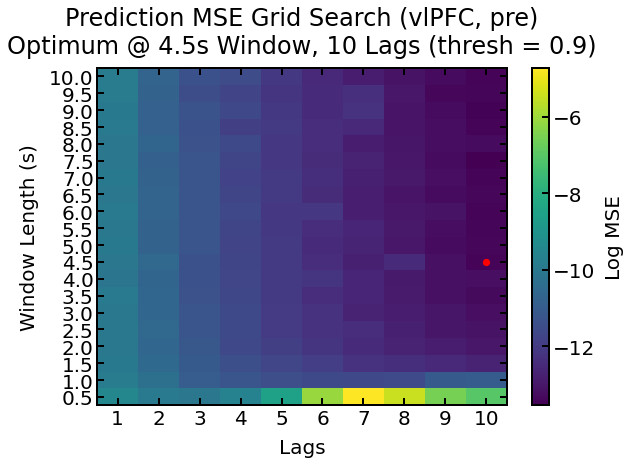

In [360]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [windows[i] for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search ({area}, {section})\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

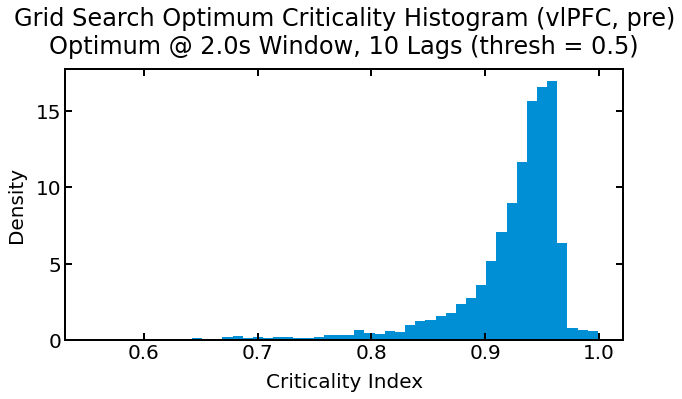

In [364]:
rows = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]
plt.title(f"Grid Search Optimum Criticality Histogram ({area}, {section})\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.hist(np.hstack(rows.criticality_inds.to_numpy()), bins=50, density=True)
plt.xlabel('Criticality Index')
plt.ylabel('Density')
plt.show()

In [365]:
thresh = 0.9
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
grid_search_09 = (w_ind, p_ind)
grid_search_optimum_09 = test_mse_mat[w_ind, p_ind]

thresh = 0.8
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
grid_search_08 = (w_ind, p_ind)
grid_search_optimum_08 = test_mse_mat[w_ind, p_ind]

thresh = 0.7
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
grid_search_07 = (w_ind, p_ind)
grid_search_optimum_07 = test_mse_mat[w_ind, p_ind]

thresh = 0.5
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
grid_search_05 = (w_ind, p_ind)
grid_search_optimum_05 = test_mse_mat[w_ind, p_ind]

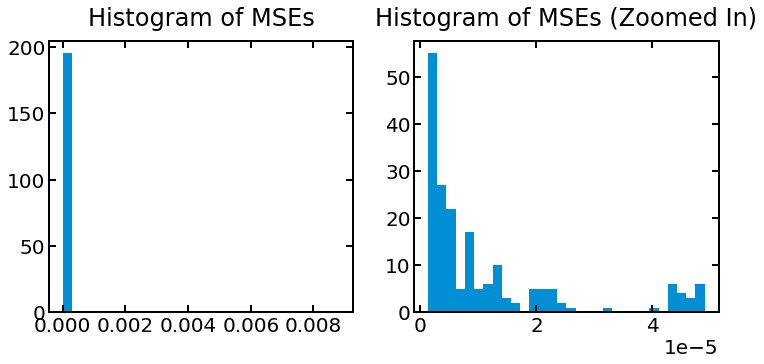

In [366]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(test_mse_mat.flatten(), bins=30)
plt.title("Histogram of MSEs")

plt.subplot(1, 2, 2)
plt.hist(test_mse_mat.flatten()[test_mse_mat.flatten() <= 0.00005], bins=30)
plt.title("Histogram of MSEs (Zoomed In)")

plt.show()

# Gradient Descent

In [367]:
convergence_thresh = 0
reps = 50

initial_points = []
chosen_points = []
num_computed_points = []

for rep in range(reps):

    i_init = np.random.randint(0, len(windows))
    j_init = np.random.randint(0, len(lags))
    
    initial_points.append((i_init, j_init))
    
    i = i_init
    j = j_init
    point_sequence = []
    mse_sequence = []

    computed_points = set()

    while True:
        point_sequence.append((i, j))
        mse_sequence.append(test_mse_mat[i, j])
        adjacent_grid_points = [(i + 1, j), (i, j + 1), (i - 1, j), (i, j - 1)]
        adjacent_grid_points = [gp for gp in adjacent_grid_points if (gp[0] in np.arange(0, len(windows)) and gp[1] in np.arange(0, len(lags)))]
        for gp in adjacent_grid_points:
            computed_points.add(gp)
        adjacent_mse_vals = [test_mse_mat[i_, j_] for (i_, j_) in adjacent_grid_points]

        min_val = np.min(adjacent_mse_vals)
        if min_val >= test_mse_mat[i, j]:
            print("Convergence reached: at a minimum")
            break
        elif test_mse_mat[i, j] - min_val < convergence_thresh:
            print("Convergence reached: change in value is less than convergence_thresh")
            break
        else:
            print(f"Continuing: step difference = {test_mse_mat[i, j] - min_val}")
            i, j = adjacent_grid_points[np.argmin(adjacent_mse_vals)]
        
    chosen_points.append((i, j))
    num_computed_points.append((len(computed_points)))

Convergence reached: at a minimum
Continuing: step difference = 3.7684397168158866e-07
Continuing: step difference = 4.630011312853167e-07
Continuing: step difference = 1.440082982219841e-07
Continuing: step difference = 1.8585324752649716e-07
Continuing: step difference = 1.8674776218852464e-07
Convergence reached: at a minimum
Continuing: step difference = 1.6993277050863474e-06
Continuing: step difference = 2.020345519199369e-06
Continuing: step difference = 8.274803354426641e-07
Continuing: step difference = 7.031506862237331e-07
Continuing: step difference = 3.7684397168158866e-07
Continuing: step difference = 4.630011312853167e-07
Continuing: step difference = 1.440082982219841e-07
Continuing: step difference = 1.8585324752649716e-07
Continuing: step difference = 1.8674776218852464e-07
Convergence reached: at a minimum
Continuing: step difference = 1.7998749423815624e-06
Continuing: step difference = 1.680507197428065e-06
Continuing: step difference = 1.2396536826651763e-06
Conti

In [368]:
gradient_descent_pts = chosen_points.copy()

In [369]:
w_ind, p_ind = np.unravel_index(test_mse_mat.argmin(), test_mse_mat.shape)
print(f"Window @ min MSE: {windows[w_ind]}")
print(f"Lag @ min MSE: {lags[p_ind]}")

print("="*50)
chosen_points = np.array(chosen_points)
avg_chosen_window = np.mean(windows[chosen_points[:, 0]])
avg_chosen_lag = np.mean(lags[chosen_points[:, 1]])
avg_num_computed_points = np.mean(num_computed_points)
print(f"Average chosen window: {avg_chosen_window}")
print(f"Average chosen lag: {avg_chosen_lag}")
print(f"Average number of computed points: {avg_num_computed_points}")

print("="*50)
print(f"Mean MSE in the matrix: {test_mse_mat.mean():.4e}")
print(f"Standard Deviation on MSE in the matrix: {test_mse_mat.std():.4e}")
print("-"*20)
val = test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].max()
print(f"Largest chosen MSE: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")
print(f"Percentile = {np.sum(test_mse_mat<=val)*100/test_mse_mat.size:.2f}")
print("-"*20)
val = test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].mean()
print(f"Average chosen MSE: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")
print(f"Percentile = {np.sum(test_mse_mat<=val)*100/test_mse_mat.size:.2f}")
print("-"*20)
val = test_mse_mat.min()
print(f"MSE at min: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")

print("="*50)
# DIST FROM MIN
print(f"Average distance from optimal window = {np.abs(windows[chosen_points[:, 0]] - windows[w_ind]).mean()}")
print(f"Average distance from optimal lag = {np.abs(lags[chosen_points[:, 1]] - lags[p_ind]).mean()}")

Window @ min MSE: 7.5
Lag @ min MSE: 10
Average chosen window: 5.89
Average chosen lag: 9.86
Average number of computed points: 16.24
Mean MSE in the matrix: 1.0056e-04
Standard Deviation on MSE in the matrix: 7.1298e-04
--------------------
Largest chosen MSE: 3.7069e-06
Distance from mean = -0.13584 std
Percentile = 33.50
--------------------
Average chosen MSE: 1.5739e-06
Distance from mean = -0.13883 std
Percentile = 6.00
--------------------
MSE at min: 1.3144e-06
Distance from mean = -0.13920 std
Average distance from optimal window = 2.59
Average distance from optimal lag = 0.14


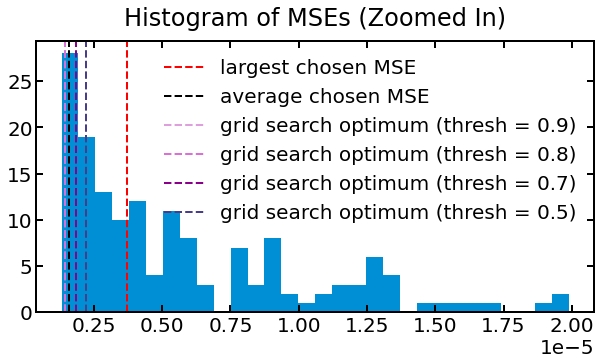

In [370]:
# plt.hist(test_mse_mat.flatten()[test_mse_mat.flatten() <= 0.00005], bins=30)
plt.hist(test_mse_mat.flatten()[test_mse_mat.flatten() <= 0.00002], bins=30)
plt.axvline(test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].max(), label='largest chosen MSE', c='r', linestyle='--')
plt.axvline(test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].mean(), label='average chosen MSE', c='k', linestyle='--')
plt.axvline(grid_search_optimum_09, label=f'grid search optimum (thresh = 0.9)', c='plum', linestyle='--')
plt.axvline(grid_search_optimum_08, label=f'grid search optimum (thresh = 0.8)', c='orchid', linestyle='--')
plt.axvline(grid_search_optimum_07, label=f'grid search optimum (thresh = 0.7)', c='darkmagenta', linestyle='--')
plt.axvline(grid_search_optimum_05, label=f'grid search optimum (thresh = 0.5)', c='darkslateblue', linestyle='--')
plt.title("Histogram of MSEs (Zoomed In)")
plt.legend()
plt.show()

# "EM" Algorithm

In [371]:
convergence_thresh = 0
reps = 50

initial_points = []
chosen_points = []
num_computed_points = []

for rep in range(reps):

    i_init = np.random.randint(0, len(windows))
    j_init = np.random.randint(0, len(lags))
    
    initial_points.append((i_init, j_init))
    
    i = i_init
    j = j_init
    point_sequence = []
    mse_sequence = []

    computed_points = set()
    
    optimize = 'windows'
    static = 0
    while True:
        point_sequence.append((i, j))
        mse_sequence.append(test_mse_mat[i, j])
        
        if optimize == 'windows':
            adjacent_grid_points = [(i_, j) for i_ in range(len(windows))]
        else: # optimize == 'lags'
            adjacent_grid_points = [(i, j_) for j_ in range(len(lags))]
            
        for gp in adjacent_grid_points:
            computed_points.add(gp)
        adjacent_mse_vals = [test_mse_mat[i_, j_] for (i_, j_) in adjacent_grid_points]
        
        w_ind, p_ind = adjacent_grid_points[np.argmin(adjacent_mse_vals)]
        
        if w_ind == i and p_ind == j:
            static += 1
            if static == 2:
                print("Convergence reached: selected point is static")
                break
        else:
            static = 0
        
            min_val = np.min(adjacent_mse_vals)

            if test_mse_mat[i, j] - min_val < convergence_thresh:
                print("Convergence reached: change in value is less than convergence_thresh")
                break
            else:
                print(f"Continuing: step difference = {test_mse_mat[i, j] - min_val}")
                i, j = adjacent_grid_points[np.argmin(adjacent_mse_vals)]
            
        if optimize == 'windows':
            optimize = 'lags'
        else:
            optimize = 'windows'
        
    chosen_points.append((i, j))
    num_computed_points.append((len(computed_points)))

Continuing: step difference = 2.1747066795886548e-06
Continuing: step difference = 8.810545309461376e-06
Continuing: step difference = 1.7478807087988716e-07
Convergence reached: selected point is static
Continuing: step difference = 8.575053580187796e-08
Convergence reached: selected point is static
Continuing: step difference = 1.8642560819143046e-07
Continuing: step difference = 6.023401008807759e-07
Continuing: step difference = 1.062661285466489e-07
Convergence reached: selected point is static
Continuing: step difference = 2.0025469992950807e-06
Continuing: step difference = 8.349475977559045e-07
Continuing: step difference = 3.997146533223122e-07
Convergence reached: selected point is static
Continuing: step difference = 3.3671240156825945e-07
Continuing: step difference = 6.909179900352038e-08
Continuing: step difference = 1.7478807087988716e-07
Convergence reached: selected point is static
Continuing: step difference = 1.6969142367849643e-07
Continuing: step difference = 3.677

In [372]:
EM_pts = chosen_points.copy()

In [373]:
w_ind, p_ind = np.unravel_index(test_mse_mat.argmin(), test_mse_mat.shape)
print(f"Window @ min MSE: {windows[w_ind]}")
print(f"Lag @ min MSE: {lags[p_ind]}")

print("="*50)
chosen_points = np.array(chosen_points)
avg_chosen_window = np.mean(windows[chosen_points[:, 0]])
avg_chosen_lag = np.mean(lags[chosen_points[:, 1]])
avg_num_computed_points = np.mean(num_computed_points)
print(f"Average chosen window: {avg_chosen_window}")
print(f"Average chosen lag: {avg_chosen_lag}")
print(f"Average number of computed points: {avg_num_computed_points}")

print("="*50)
print(f"Mean MSE in the matrix: {test_mse_mat.mean():.4e}")
print(f"Standard Deviation on MSE in the matrix: {test_mse_mat.std():.4e}")
print("-"*20)
val = test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].max()
print(f"Largest chosen MSE: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")
print(f"Percentile = {np.sum(test_mse_mat<=val)*100/test_mse_mat.size:.2f}")
print("-"*20)
val = test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].mean()
print(f"Average chosen MSE: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")
print(f"Percentile = {np.sum(test_mse_mat<=val)*100/test_mse_mat.size:.2f}")
print("-"*20)
val = test_mse_mat.min()
print(f"MSE at min: {val:.4e}")
print(f"Distance from mean = {(val - test_mse_mat.mean())/test_mse_mat.std():.5f} std")

print("="*50)
# DIST FROM MIN
print(f"Average distance from optimal window = {np.abs(windows[chosen_points[:, 0]] - windows[w_ind]).mean()}")
print(f"Average distance from optimal lag = {np.abs(lags[chosen_points[:, 1]] - lags[p_ind]).mean()}")

Window @ min MSE: 7.5
Lag @ min MSE: 10
Average chosen window: 7.5
Average chosen lag: 10.0
Average number of computed points: 52.5
Mean MSE in the matrix: 1.0056e-04
Standard Deviation on MSE in the matrix: 7.1298e-04
--------------------
Largest chosen MSE: 1.3144e-06
Distance from mean = -0.13920 std
Percentile = 0.50
--------------------
Average chosen MSE: 1.3144e-06
Distance from mean = -0.13920 std
Percentile = 0.00
--------------------
MSE at min: 1.3144e-06
Distance from mean = -0.13920 std
Average distance from optimal window = 0.0
Average distance from optimal lag = 0.0


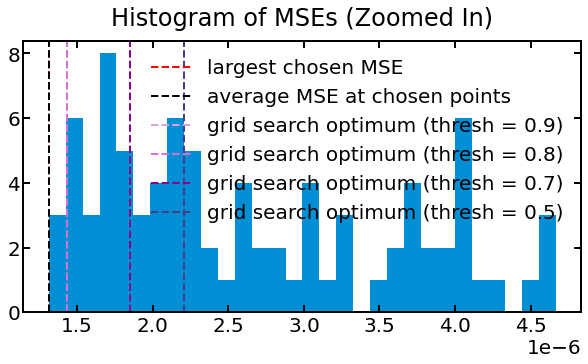

In [374]:
plt.hist(test_mse_mat.flatten()[test_mse_mat.flatten() <= 0.000005], bins=30)
plt.axvline(test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].max(), label='largest chosen MSE', c='r', linestyle='--')
plt.axvline(test_mse_mat[chosen_points[:, 0], chosen_points[:, 1]].mean(), label='average MSE at chosen points', c='k', linestyle='--')
plt.axvline(grid_search_optimum_09, label=f'grid search optimum (thresh = 0.9)', c='plum', linestyle='--')
plt.axvline(grid_search_optimum_08, label=f'grid search optimum (thresh = 0.8)', c='orchid', linestyle='--')
plt.axvline(grid_search_optimum_07, label=f'grid search optimum (thresh = 0.7)', c='darkmagenta', linestyle='--')
plt.axvline(grid_search_optimum_05, label=f'grid search optimum (thresh = 0.5)', c='darkslateblue', linestyle='--')
plt.title("Histogram of MSEs (Zoomed In)")
plt.legend()
plt.show()

# Visualize Points

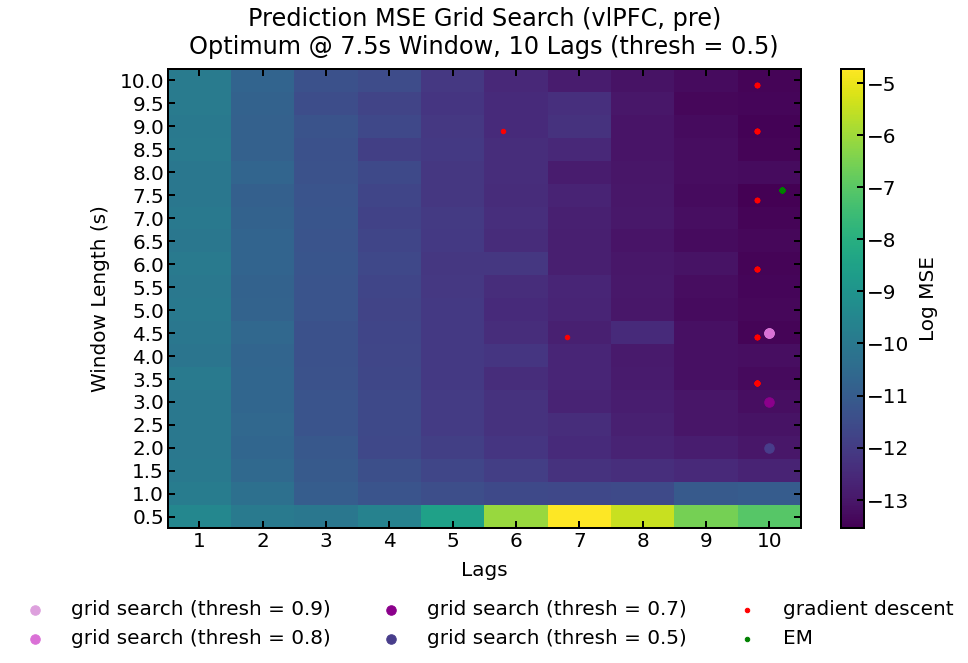

In [375]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
fig = plt.figure(figsize=(14, 8))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [windows[i] for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
grid_search_pts = [grid_search_09, grid_search_08, grid_search_07, grid_search_05]
grid_search_labels = ['grid search (thresh = 0.9)', 'grid search (thresh = 0.8)', 'grid search (thresh = 0.7)', 'grid search (thresh = 0.5)']
colors = ['plum', 'orchid', 'darkmagenta', 'darkslateblue']
for pt, label, c in zip(grid_search_pts, grid_search_labels, colors):
    w_ind, p_ind = pt
    plt.scatter([p_ind + 0.5], [w_ind + 0.5], color=c, s=90, label=label)

for i, pt in enumerate(gradient_descent_pts):
    w_ind, p_ind = pt
    if i == 0:
        plt.scatter([p_ind + 0.3], [w_ind + 0.3], color='red', s=20, label='gradient descent')
    else:
        plt.scatter([p_ind + 0.3], [w_ind + 0.3], color='red', s=20)

for i, pt in enumerate(EM_pts):
    w_ind, p_ind = pt
    if i == 0:
        plt.scatter([p_ind + 0.7], [w_ind + 0.7], color='green', s=20, label='EM')
    else:
        plt.scatter([p_ind + 0.7], [w_ind + 0.7], color='green', s=20)
    
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
fig.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search ({area}, {section})\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Load Neural Data

In [379]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

spike_times = spike_times[0]

# Test Residuals

In [405]:
w_ind, p_ind = grid_search_09
p_ind = 3 - 1 # lag of 3
rows = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

In [406]:
row = rows.iloc[0]
area = row.area
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [407]:
pred_data = lfp[row.end_ind - row.p:row.end_ind + row.T_pred]
prediction, true_vals = predict_VAR_p(pred_data, row.coefs, row.intercept, unit_indices)

In [408]:
residuals = prediction - true_vals

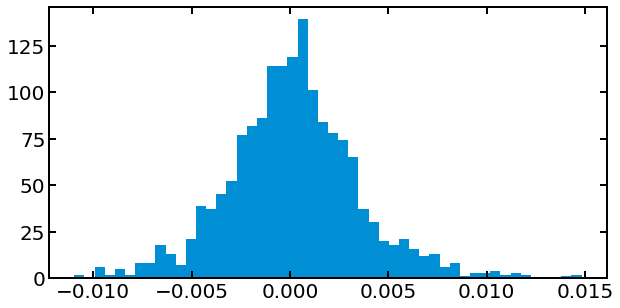

In [409]:
plt.hist(residuals.flatten(), bins=50)
plt.show()